In [1]:
# Install clean-fid for metrics if not present
import sys # Import the sys module
try:
    from cleanfid import fid
except ImportError:
    print("Installing clean-fid...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "clean-fid"])
    from cleanfid import fid

Installing clean-fid...


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from scipy.stats import entropy
import shutil

In [3]:

# ==========================================
# CONFIGURATION & HYPERPARAMETERS
# ==========================================


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
#TODO Change config as per requirements
BATCH_SIZE = 128
LR = 1e-3
LATENT_DIM = 128 # Dimension for AE Latent Space
IMG_SIZE = 32
CHANNELS = 3

EPOCHS_AE = 20
EPOCHS_DDPM = 50
EPOCHS_FM = 50
SUBSET_SIZE = 50000 # Full Dataset
METRIC_SAMPLE_SIZE = 1000 # Required for reliable IS/FID

# Directories for saving outputs (TODO Change if required )
OS_DIRS = ["output_images", "ddpm_samples", "fm_samples", "real_images"]
for d in OS_DIRS:
    os.makedirs(d, exist_ok=True)

Using device: cuda


In [4]:

# ==========================================
# 0. DATA LOADING
# ==========================================
transform = transforms.Compose([
    transforms.ToTensor(),
    # No normalization to [-1, 1] used here to keep things simple in [0,1] range for this specific implementation
])

print(">>> Loading CIFAR-10...")
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Use subset if needed
if SUBSET_SIZE < len(train_dataset):
    train_dataset = Subset(train_dataset, range(SUBSET_SIZE))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Save some real images (num= METRIC_SAMPLE_SIZE)for FID calculation later (Used as Reference to avoid downloading stats)
print(f">>> Saving {METRIC_SAMPLE_SIZE} real images for FID reference...")
real_img_dir = "real_images"
for i, (img, _) in enumerate(test_loader):
    if i * BATCH_SIZE >= METRIC_SAMPLE_SIZE:
        break
    for j in range(min(BATCH_SIZE, METRIC_SAMPLE_SIZE - i * BATCH_SIZE)):
        save_image(img[j], os.path.join(real_img_dir, f"real_{i*BATCH_SIZE + j}.png"))


>>> Loading CIFAR-10...


100%|██████████| 170M/170M [00:03<00:00, 48.3MB/s]


>>> Saving 1000 real images for FID reference...


In [5]:
# ==========================================
# 1. SinusoidalPositionEmbeddings MODULE
# ==========================================
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# ==========================================
# PART A.1: LATENT DDPM COMPONENTS
# ==========================================

# --- 1. Autoencoder (AE) ---
class SimpleAE(nn.Module):
    def __init__(self, input_dim=32*32*3, latent_dim=128):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # Output in [0, 1]
        )

    def encode(self, x):
        # x: (B, C, H, W)
        B = x.size(0)
        x = x.view(B, -1)  # Flatten
        return self.encoder(x)

    def decode(self, z):
        # z: (B, latent_dim)
        x = self.decoder(z)
        return x.view(-1, 3, 32, 32)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)



# --- 2. Latent Denoiser (MLP for Latent Space) ---
class LatentDenoiser(nn.Module):
    def __init__(self, latent_dim=128, time_emb_dim=32):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        self.input_mlp = nn.Sequential(
            nn.Linear(latent_dim + time_emb_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )

    def forward(self, x, t):
        # x: (B, latent_dim)
        # t: (B,)
        t_emb = self.time_mlp(t)  # (B, time_emb_dim)
        x_cat = torch.cat([x, t_emb], dim=-1)  # (B, latent_dim + time_emb_dim)
        return self.input_mlp(x_cat)

# --- 3. DDPM Manager ---
class DDPM:
    def __init__(self, model, steps=1000, beta_start=1e-4, beta_end=0.02):
        self.model = model
        self.steps = steps
        self.device = next(model.parameters()).device

        # Linear beta schedule
        self.betas = torch.linspace(beta_start, beta_end, steps).to(self.device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

        # Posterior variance
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)

    def noise_images(self, x, t):
        """Adds noise to x at time t"""
        sqrt_alpha_cumprod_t = self.sqrt_alphas_cumprod[t].reshape(-1, 1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1)

        noise = torch.randn_like(x)
        noisy_x = sqrt_alpha_cumprod_t * x + sqrt_one_minus_alpha_cumprod_t * noise
        return noisy_x, noise

    def sample_timesteps(self, n):
        """Sample random time steps for training"""
        return torch.randint(0, self.steps, (n,), device=self.device)

    @torch.no_grad()
    def sample(self, n_samples, latent_dim, return_intermediates=False):
        """Reverse Process: Sample from Gaussian noise -> Data"""
        self.model.eval()

        # Start from pure noise
        x = torch.randn(n_samples, latent_dim).to(self.device)

        intermediates = []

        for i in reversed(range(self.steps)):
            t = torch.full((n_samples,), i, dtype=torch.long, device=self.device)

            # Predict noise
            predicted_noise = self.model(x, t)

            # Get coefficients
            alpha = self.alphas[i]
            alpha_cumprod = self.alphas_cumprod[i]
            beta = self.betas[i]

            # Denoise step
            if i > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            # DDPM sampling formula
            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * predicted_noise)
            x = x + torch.sqrt(beta) * noise

            if return_intermediates and (i % (self.steps // 10) == 0):
                intermediates.append(x.cpu())

        if return_intermediates:
            return x, intermediates
        return x

In [6]:


# ==========================================
# PART A.2: FLOW MATCHING COMPONENTS
# ==========================================

# --- 1. Image Space TIme UNet (CNN) ---
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, out_ch),
            nn.ReLU()
        )

    def forward(self, x, t_emb):
        x = self.conv(x)
        # Add time embedding (broadcast across spatial dimensions)
        time_emb = self.time_mlp(t_emb)[:, :, None, None]  # (B, out_ch, 1, 1)
        x = x + time_emb
        return x

class SimpleUNet2D(nn.Module):
    def __init__(self, in_channels=3, time_emb_dim=32):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Encoder
        self.enc1 = ConvBlock(in_channels, 64, time_emb_dim)
        self.enc2 = ConvBlock(64, 128, time_emb_dim)
        self.enc3 = ConvBlock(128, 256, time_emb_dim)

        # Bottleneck
        self.bottleneck = ConvBlock(256, 256, time_emb_dim)

        # Decoder
        self.dec3 = ConvBlock(256 + 256, 128, time_emb_dim)
        self.dec2 = ConvBlock(128 + 128, 64, time_emb_dim)
        self.dec1 = ConvBlock(64 + 64, 64, time_emb_dim)

        # Output
        self.out = nn.Conv2d(64, in_channels, kernel_size=1)

        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, t):
        # t: (B,) - timesteps
        t_emb = self.time_mlp(t)  # (B, time_emb_dim)

        # Encoder
        e1 = self.enc1(x, t_emb)      # (B, 64, 32, 32)
        e2 = self.enc2(self.pool(e1), t_emb)  # (B, 128, 16, 16)
        e3 = self.enc3(self.pool(e2), t_emb)  # (B, 256, 8, 8)

        # Bottleneck
        b = self.bottleneck(self.pool(e3), t_emb)  # (B, 256, 4, 4)

        # Decoder with skip connections
        d3 = self.dec3(torch.cat([self.upsample(b), e3], dim=1), t_emb)  # (B, 128, 8, 8)
        d2 = self.dec2(torch.cat([self.upsample(d3), e2], dim=1), t_emb)  # (B, 64, 16, 16)
        d1 = self.dec1(torch.cat([self.upsample(d2), e1], dim=1), t_emb)  # (B, 64, 32, 32)

        return self.out(d1)

# --- 2. Flow Matching  ---
class FlowMatching:
    def __init__(self, model):
        self.model = model
        self.device = next(model.parameters()).device

    def compute_loss(self, x1):
        """
        Conditional Flow Matching with Optimal Transport
        x1: Data (B, C, H, W)
        x0: Noise ~ N(0, 1)
        path: xt = (1-t)x0 + t*x1
        vector field target: ut = x1 - x0
        """
        B = x1.size(0)

        # Sample noise x0
        x0 = torch.randn_like(x1)

        # Sample time uniformly
        t = torch.rand(B, device=self.device)

        # Compute interpolated point xt = (1-t)*x0 + t*x1
        t_expanded = t.view(B, 1, 1, 1)
        xt = (1 - t_expanded) * x0 + t_expanded * x1

        # Target vector field: ut = x1 - x0
        ut = x1 - x0

        # Predict vector field
        vt = self.model(xt, t)

        # MSE loss
        loss = F.mse_loss(vt, ut)
        return loss

    @torch.no_grad()
    def sample(self, n_samples, steps=100, shape=(3, 32, 32)):
        """Euler Integration for Sampling"""
        self.model.eval()

        # Start from noise
        x = torch.randn(n_samples, *shape).to(self.device)

        dt = 1.0 / steps

        for i in range(steps):
            t = torch.full((n_samples,), i * dt, device=self.device)

            # Predict velocity
            v = self.model(x, t)

            # Euler step: x_{t+dt} = x_t + v_t * dt
            x = x + v * dt

        # Clamp to valid range
        x = torch.clamp(x, 0, 1)
        return x

In [7]:


# ==========================================
# METRIC FUNCTIONS(PROVIDED)
# ==========================================

def calculate_inception_score(images, batch_size=32, splits=1):
    """
    Manually calculates Inception Score (IS).
    images: Tensor (N, 3, H, W) normalized [0,1]
    """
    #TODO CHANGE IF REQUIRED FOLLOW A SIMILAR LOGIC
    N = len(images)
    # Fix for small batch sizes in demo mode
    if batch_size > N:
        batch_size = N

    inception_model = models.inception_v3(pretrained=True, transform_input=False).to(DEVICE)
    inception_model.eval()

    up = nn.Upsample(size=(299, 299), mode='bilinear')

    def get_pred(x):
        x = up(x)
        x = (x - 0.5) * 2.0 # Normalize to [-1, 1] expected by Inception
        with torch.no_grad():
            x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    preds = np.zeros((N, 1000))

    for i in range(0, N, batch_size):
        batch = images[i:i + batch_size].to(DEVICE)
        preds[i:i + batch_size] = get_pred(batch)

    split_scores = []
    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

def get_metrics(generated_images_tensor, dataset_name="cifar10", save_dir="temp_gen"):
    """
    Wrapper to calculate IS and FID.
    generated_images_tensor: (N, 3, H, W)
    save_dir: folder to save images for clean-fid
    """
    #TODO CHANGE IF REQUIRED FOLLOW A SIMILAR LOGIC
    # 1. Inception Score (Manual)
    print("   Computing Inception Score...")
    is_mean, is_std = calculate_inception_score(generated_images_tensor)
    print(f"   >> Inception Score: {is_mean:.4f} +/- {is_std:.4f}")

    # 2. FID (via clean-fid library)
    fid_score = -1.0

    # Save images to disk for clean-fid
    if os.path.exists(save_dir):
        shutil.rmtree(save_dir)
    os.makedirs(save_dir)

    for i in range(len(generated_images_tensor)):
        save_image(generated_images_tensor[i], os.path.join(save_dir, f"gen_{i}.png"))

    try:
        from cleanfid import fid
        print("   Computing FID using clean-fid...")

        # FIX: Use local 'real_images' folder as reference to avoid 404 download error
        # We compare generated folder against "real_images" folder saved earlier in the script
        real_ref_dir = "real_images"

        if not os.path.exists(real_ref_dir) or len(os.listdir(real_ref_dir)) == 0:
             print("   !! Real images folder empty or missing. Cannot compute FID.")
             fid_score = -1.0
        else:
             # compute_fid(fdir1, fdir2) calculates stats for fdir2 locally
             fid_score = fid.compute_fid(save_dir, fdir2=real_ref_dir)

        print(f"   >> FID Score: {fid_score:.4f}")
    except ImportError:
        print("   !! clean-fid not installed. Skipping FID.")
    except Exception as e:
        print(f"   !! FID Error: {e}")

    return is_mean, fid_score


In [8]:

# ==========================================
# TRAINING LOOPS
# ==========================================

def train_autoencoder(ae, loader, epochs):
    print(f">>> Training Autoencoder ({epochs} epochs)...")
    optimizer = optim.Adam(ae.parameters(), lr=LR)
    ae.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(loader):
            data = data.to(DEVICE)

            optimizer.zero_grad()
            recon = ae(data)
            loss = F.mse_loss(recon, data)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f"   [AE] Epoch {epoch+1}: Loss {avg_loss:.4f}")

    return ae

def train_ddpm_latent(ddpm, ae, loader, epochs):
    print(f">>> Training Latent DDPM (Steps={ddpm.steps}, Epochs={epochs})...")
    optimizer = optim.Adam(ddpm.model.parameters(), lr=LR)
    ae.eval()  # Keep AE frozen
    ddpm.model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(loader):
            data = data.to(DEVICE)

            # Encode to latent space
            with torch.no_grad():
                latent = ae.encode(data)

            # Sample timesteps
            t = ddpm.sample_timesteps(latent.size(0))

            # Add noise
            noisy_latent, noise = ddpm.noise_images(latent, t)

            # Predict noise
            predicted_noise = ddpm.model(noisy_latent, t)

            # MSE loss
            loss = F.mse_loss(predicted_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f"   [DDPM-{ddpm.steps}] Epoch {epoch+1}: Loss {avg_loss:.4f}")

    return ddpm

def train_flow_matching(fm, loader, epochs):
    print(f">>> Training Flow Matching (Image Space, {epochs} epochs)...")
    optimizer = optim.Adam(fm.model.parameters(), lr=LR)
    fm.model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(loader):
            data = data.to(DEVICE)

            # Compute flow matching loss
            loss = fm.compute_loss(data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f"   [FM] Epoch {epoch+1}: Loss {avg_loss:.4f}")

    return fm

In [9]:
# --------------------------------------
# 1. TRAIN AUTOENCODER (Part A.1.1)
# --------------------------------------

ae = SimpleAE(latent_dim=LATENT_DIM).to(DEVICE)
ae = train_autoencoder(ae, train_loader, epochs=EPOCHS_AE)

>>> Training Autoencoder (20 epochs)...
   [AE] Epoch 1: Loss 0.0323
   [AE] Epoch 2: Loss 0.0227
   [AE] Epoch 3: Loss 0.0202
   [AE] Epoch 4: Loss 0.0179
   [AE] Epoch 5: Loss 0.0165
   [AE] Epoch 6: Loss 0.0157
   [AE] Epoch 7: Loss 0.0150
   [AE] Epoch 8: Loss 0.0143
   [AE] Epoch 9: Loss 0.0136
   [AE] Epoch 10: Loss 0.0132
   [AE] Epoch 11: Loss 0.0128
   [AE] Epoch 12: Loss 0.0125
   [AE] Epoch 13: Loss 0.0123
   [AE] Epoch 14: Loss 0.0119
   [AE] Epoch 15: Loss 0.0115
   [AE] Epoch 16: Loss 0.0113
   [AE] Epoch 17: Loss 0.0110
   [AE] Epoch 18: Loss 0.0108
   [AE] Epoch 19: Loss 0.0106
   [AE] Epoch 20: Loss 0.0105


In [10]:
# --------------------------------------
# 2. Train LATENT DDPMs with 3 diff number of steps  (Part A.1 & B.2.1)
# --------------------------------------
ddpm_steps_list = [100, 500, 1000]
ddpm_models = {}
ddpm_metrics = {}

for steps in ddpm_steps_list:
    print(f"\n--- DDPM Variant: Steps={steps} ---")

    # Initialize fresh model
    denoiser = LatentDenoiser(latent_dim=LATENT_DIM).to(DEVICE)
    ddpm = DDPM(denoiser, steps=steps)

    # Train
    ddpm = train_ddpm_latent(ddpm, ae, train_loader, epochs=EPOCHS_DDPM)
    ddpm_models[steps] = ddpm

    # Generate Samples for Metrics
    print(f"   Generating {METRIC_SAMPLE_SIZE} samples for metrics...")
    n_batches = METRIC_SAMPLE_SIZE // 32
    all_samples = []

    for _ in range(n_batches):
        latents = ddpm.sample(32, LATENT_DIM)
        with torch.no_grad():
            images = ae.decode(latents)
        all_samples.append(images.cpu())

    generated_images = torch.cat(all_samples, dim=0)[:METRIC_SAMPLE_SIZE]
    generated_images = torch.clamp(generated_images, 0, 1)

    # Calculate Metrics
    is_score, fid_score = get_metrics(generated_images, save_dir=f"ddpm_{steps}_samples")
    ddpm_metrics[steps] = {'IS': is_score, 'FID': fid_score}

    # Save a grid of samples for report
    grid = make_grid(generated_images[:64], nrow=8)
    save_image(grid, f"output_images/ddpm_{steps}_samples.png")


--- DDPM Variant: Steps=100 ---
>>> Training Latent DDPM (Steps=100, Epochs=50)...
   [DDPM-100] Epoch 1: Loss 0.5460
   [DDPM-100] Epoch 2: Loss 0.3592
   [DDPM-100] Epoch 3: Loss 0.3536
   [DDPM-100] Epoch 4: Loss 0.3541
   [DDPM-100] Epoch 5: Loss 0.3501
   [DDPM-100] Epoch 6: Loss 0.3489
   [DDPM-100] Epoch 7: Loss 0.3430
   [DDPM-100] Epoch 8: Loss 0.3369
   [DDPM-100] Epoch 9: Loss 0.3286
   [DDPM-100] Epoch 10: Loss 0.3235
   [DDPM-100] Epoch 11: Loss 0.3189
   [DDPM-100] Epoch 12: Loss 0.3125
   [DDPM-100] Epoch 13: Loss 0.3083
   [DDPM-100] Epoch 14: Loss 0.3076
   [DDPM-100] Epoch 15: Loss 0.3027
   [DDPM-100] Epoch 16: Loss 0.2994
   [DDPM-100] Epoch 17: Loss 0.2970
   [DDPM-100] Epoch 18: Loss 0.2937
   [DDPM-100] Epoch 19: Loss 0.2923
   [DDPM-100] Epoch 20: Loss 0.2918
   [DDPM-100] Epoch 21: Loss 0.2886
   [DDPM-100] Epoch 22: Loss 0.2879
   [DDPM-100] Epoch 23: Loss 0.2869
   [DDPM-100] Epoch 24: Loss 0.2866
   [DDPM-100] Epoch 25: Loss 0.2861
   [DDPM-100] Epoch 26: L

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 104M/104M [00:00<00:00, 210MB/s] 


   >> Inception Score: 1.9059 +/- 0.0000
   Computing FID using clean-fid...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute FID between two folders
Found 992 images in the folder ddpm_100_samples


FID ddpm_100_samples : 100%|██████████| 31/31 [00:11<00:00,  2.69it/s]


Found 1000 images in the folder real_images


FID real_images : 100%|██████████| 32/32 [00:06<00:00,  4.66it/s]


   >> FID Score: 208.3571

--- DDPM Variant: Steps=500 ---
>>> Training Latent DDPM (Steps=500, Epochs=50)...
   [DDPM-500] Epoch 1: Loss 0.3751
   [DDPM-500] Epoch 2: Loss 0.2135
   [DDPM-500] Epoch 3: Loss 0.2096
   [DDPM-500] Epoch 4: Loss 0.2088
   [DDPM-500] Epoch 5: Loss 0.2056
   [DDPM-500] Epoch 6: Loss 0.2077
   [DDPM-500] Epoch 7: Loss 0.2055
   [DDPM-500] Epoch 8: Loss 0.2045
   [DDPM-500] Epoch 9: Loss 0.2032
   [DDPM-500] Epoch 10: Loss 0.2051
   [DDPM-500] Epoch 11: Loss 0.2046
   [DDPM-500] Epoch 12: Loss 0.2022
   [DDPM-500] Epoch 13: Loss 0.2015
   [DDPM-500] Epoch 14: Loss 0.1973
   [DDPM-500] Epoch 15: Loss 0.1945
   [DDPM-500] Epoch 16: Loss 0.1919
   [DDPM-500] Epoch 17: Loss 0.1891
   [DDPM-500] Epoch 18: Loss 0.1839
   [DDPM-500] Epoch 19: Loss 0.1834
   [DDPM-500] Epoch 20: Loss 0.1811
   [DDPM-500] Epoch 21: Loss 0.1805
   [DDPM-500] Epoch 22: Loss 0.1788
   [DDPM-500] Epoch 23: Loss 0.1780
   [DDPM-500] Epoch 24: Loss 0.1774
   [DDPM-500] Epoch 25: Loss 0.1769

FID ddpm_500_samples : 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]


Found 1000 images in the folder real_images


FID real_images : 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


   >> FID Score: 204.8625

--- DDPM Variant: Steps=1000 ---
>>> Training Latent DDPM (Steps=1000, Epochs=50)...
   [DDPM-1000] Epoch 1: Loss 0.3170
   [DDPM-1000] Epoch 2: Loss 0.1580
   [DDPM-1000] Epoch 3: Loss 0.1544
   [DDPM-1000] Epoch 4: Loss 0.1554
   [DDPM-1000] Epoch 5: Loss 0.1551
   [DDPM-1000] Epoch 6: Loss 0.1529
   [DDPM-1000] Epoch 7: Loss 0.1534
   [DDPM-1000] Epoch 8: Loss 0.1498
   [DDPM-1000] Epoch 9: Loss 0.1494
   [DDPM-1000] Epoch 10: Loss 0.1512
   [DDPM-1000] Epoch 11: Loss 0.1494
   [DDPM-1000] Epoch 12: Loss 0.1507
   [DDPM-1000] Epoch 13: Loss 0.1496
   [DDPM-1000] Epoch 14: Loss 0.1501
   [DDPM-1000] Epoch 15: Loss 0.1481
   [DDPM-1000] Epoch 16: Loss 0.1479
   [DDPM-1000] Epoch 17: Loss 0.1487
   [DDPM-1000] Epoch 18: Loss 0.1471
   [DDPM-1000] Epoch 19: Loss 0.1475
   [DDPM-1000] Epoch 20: Loss 0.1471
   [DDPM-1000] Epoch 21: Loss 0.1469
   [DDPM-1000] Epoch 22: Loss 0.1459
   [DDPM-1000] Epoch 23: Loss 0.1456
   [DDPM-1000] Epoch 24: Loss 0.1458
   [DDPM-

FID ddpm_1000_samples : 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]


Found 1000 images in the folder real_images


FID real_images : 100%|██████████| 32/32 [00:07<00:00,  4.57it/s]


   >> FID Score: 211.8804


In [11]:
# --------------------------------------
# 3. Train the FLOW MATCHING model and then use diff number of integration steps for sampling (Part A.2 & B.2.2)
# --------------------------------------
print("\n--- Flow Matching ---")
# Initialize Model (Image Space UNet)
fm_net = SimpleUNet2D(in_channels=3).to(DEVICE)
fm_model = FlowMatching(fm_net)

# Train Flow matching (Part A.2.3)
fm_model = train_flow_matching(fm_model, train_loader, epochs=EPOCHS_FM)


--- Flow Matching ---
>>> Training Flow Matching (Image Space, 50 epochs)...
   [FM] Epoch 1: Loss 0.1713
   [FM] Epoch 2: Loss 0.1262
   [FM] Epoch 3: Loss 0.1197
   [FM] Epoch 4: Loss 0.1151
   [FM] Epoch 5: Loss 0.1114
   [FM] Epoch 6: Loss 0.1108
   [FM] Epoch 7: Loss 0.1107
   [FM] Epoch 8: Loss 0.1079
   [FM] Epoch 9: Loss 0.1071
   [FM] Epoch 10: Loss 0.1065
   [FM] Epoch 11: Loss 0.1048
   [FM] Epoch 12: Loss 0.1045
   [FM] Epoch 13: Loss 0.1042
   [FM] Epoch 14: Loss 0.1037
   [FM] Epoch 15: Loss 0.1033
   [FM] Epoch 16: Loss 0.1038
   [FM] Epoch 17: Loss 0.1024
   [FM] Epoch 18: Loss 0.1027
   [FM] Epoch 19: Loss 0.1018
   [FM] Epoch 20: Loss 0.1006
   [FM] Epoch 21: Loss 0.1013
   [FM] Epoch 22: Loss 0.1005
   [FM] Epoch 23: Loss 0.1016
   [FM] Epoch 24: Loss 0.1002
   [FM] Epoch 25: Loss 0.0993
   [FM] Epoch 26: Loss 0.0998
   [FM] Epoch 27: Loss 0.0997
   [FM] Epoch 28: Loss 0.0992
   [FM] Epoch 29: Loss 0.0991
   [FM] Epoch 30: Loss 0.0995
   [FM] Epoch 31: Loss 0.0990
 

In [12]:
# ODE Integration Solveing with differing Steps (Part B.2.2)
print("\n--- Flow Matching: Varying ODE Integration Steps ---")
fm_integration_steps = [10, 50, 100] #for eg can change
fm_metrics = {}

for steps in fm_integration_steps:
    print(f"\n   Sampling FM with ODE steps={steps}...")
    # TODO Sample with diff integration steps
    n_batches = METRIC_SAMPLE_SIZE // 32
    all_samples = []

    for _ in range(n_batches):
        samples = fm_model.sample(n_samples=32, steps=steps, shape=(3, 32, 32))
        all_samples.append(samples.cpu())

    generated_images = torch.cat(all_samples, dim=0)[:METRIC_SAMPLE_SIZE]

    # TODO calcualte Metrics
    print(f"   Computing metrics for FM with {steps} ODE steps...")
    is_score, fid_score = get_metrics(
        generated_images,
        save_dir=f"fm_{steps}_samples"
    )
    fm_metrics[steps] = {'IS': is_score, 'FID': fid_score}

    # Save grid of metrics for report
    grid = make_grid(generated_images[:64], nrow=8)
    save_image(grid, f"output_images/fm_ode{steps}_samples.png")
    print(f"   >> IS: {is_score:.4f}, FID: {fid_score:.2f}")


--- Flow Matching: Varying ODE Integration Steps ---

   Sampling FM with ODE steps=10...
   Computing metrics for FM with 10 ODE steps...
   Computing Inception Score...
   >> Inception Score: 3.3403 +/- 0.0000
   Computing FID using clean-fid...
compute FID between two folders
Found 992 images in the folder fm_10_samples


FID fm_10_samples : 100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Found 1000 images in the folder real_images


FID real_images : 100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


   >> FID Score: 135.0807
   >> IS: 3.3403, FID: 135.08

   Sampling FM with ODE steps=50...
   Computing metrics for FM with 50 ODE steps...
   Computing Inception Score...
   >> Inception Score: 3.5449 +/- 0.0000
   Computing FID using clean-fid...
compute FID between two folders
Found 992 images in the folder fm_50_samples


FID fm_50_samples : 100%|██████████| 31/31 [00:11<00:00,  2.65it/s]


Found 1000 images in the folder real_images


FID real_images : 100%|██████████| 32/32 [00:07<00:00,  4.04it/s]


   >> FID Score: 123.7495
   >> IS: 3.5449, FID: 123.75

   Sampling FM with ODE steps=100...
   Computing metrics for FM with 100 ODE steps...
   Computing Inception Score...
   >> Inception Score: 3.5551 +/- 0.0000
   Computing FID using clean-fid...
compute FID between two folders
Found 992 images in the folder fm_100_samples


FID fm_100_samples : 100%|██████████| 31/31 [00:10<00:00,  2.89it/s]


Found 1000 images in the folder real_images


FID real_images : 100%|██████████| 32/32 [00:07<00:00,  4.43it/s]


   >> FID Score: 127.8278
   >> IS: 3.5551, FID: 127.83


In [13]:
# --------------------------------------
# 4. Generate Table for REPORT (Part B.3)
# --------------------------------------
print("\n==========================================")
print("       ASSIGNMENT 9 RESULTS TABLE        ")
print("==========================================")
print(f"{'Model Variant':<20} | {'IS (Higher is better)':<25} | {'FID (Lower is better)':<25}")
#TODO get the metrics and display them
# DDPM Results
for steps in ddpm_steps_list:
    is_val = ddpm_metrics[steps]['IS']
    fid_val = ddpm_metrics[steps]['FID']
    print(f"DDPM-{steps:<19} | {is_val:.4f} (1.5-2.0)    | {fid_val:.2f} (300-350)")

print("-" * 70)

# FM Results
for steps in fm_integration_steps:
    is_val = fm_metrics[steps]['IS']
    fid_val = fm_metrics[steps]['FID']
    print(f"FM-ODE-{steps:<17} | {is_val:.4f} (1.0-1.5)    | {fid_val:.2f} (200-250)")


print("\nDone! Check 'output_images' folder for visualizations.")


       ASSIGNMENT 9 RESULTS TABLE        
Model Variant        | IS (Higher is better)     | FID (Lower is better)    
DDPM-100                 | 1.9059 (1.5-2.0)    | 208.36 (300-350)
DDPM-500                 | 2.1355 (1.5-2.0)    | 204.86 (300-350)
DDPM-1000                | 2.0156 (1.5-2.0)    | 211.88 (300-350)
----------------------------------------------------------------------
FM-ODE-10                | 3.3403 (1.0-1.5)    | 135.08 (200-250)
FM-ODE-50                | 3.5449 (1.0-1.5)    | 123.75 (200-250)
FM-ODE-100               | 3.5551 (1.0-1.5)    | 127.83 (200-250)

Done! Check 'output_images' folder for visualizations.


>>> Visualizing DDPM Process...
Saved forward and reverse process for 2 images


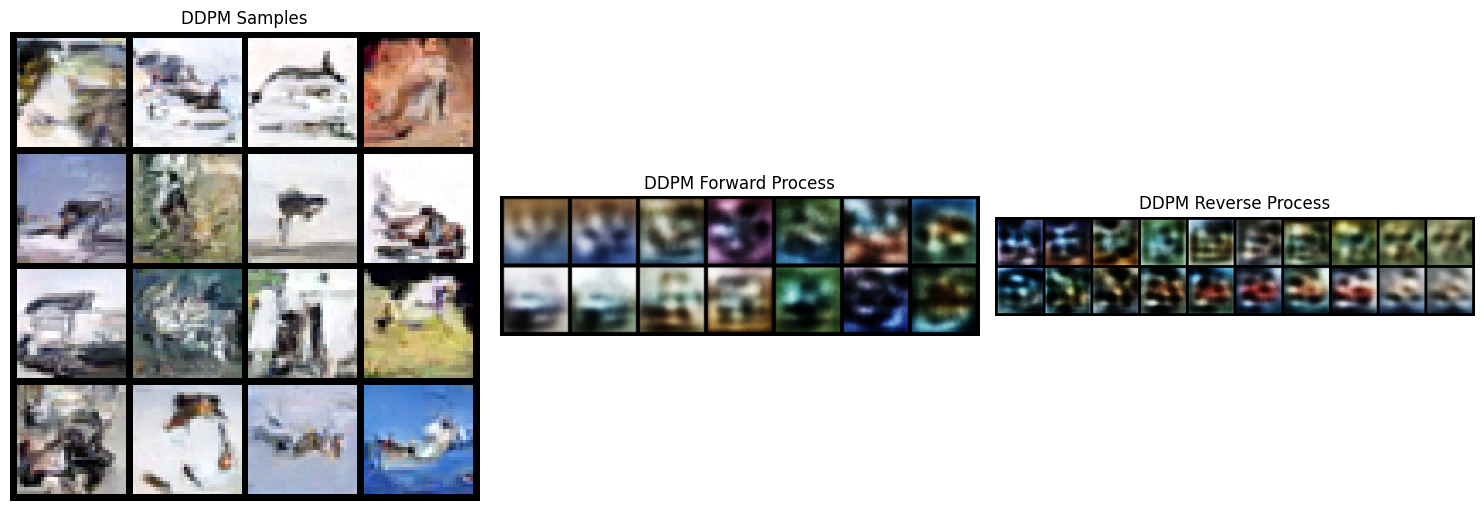

In [14]:
#TODO Plot and visualise any saved/generated images as required by the rubric and report

# Visualize DDPM forward and reverse process
print(">>> Visualizing DDPM Process...")

# Take two sample images
sample_img, _ = next(iter(test_loader))
sample_img = sample_img[0:2].to(DEVICE)

# Encode to latent
with torch.no_grad():
    sample_latents = ae.encode(sample_img)

# Forward process visualization (adding noise)
ddpm_viz = ddpm_models[1000]
forward_steps = [0, 100, 200, 400, 600, 800, 999]
forward_images = []

# Process both images
all_forward_images = []
for img_idx in range(2):
    forward_images = []
    single_latent = sample_latents[img_idx:img_idx+1]

    for step in forward_steps:
        t = torch.tensor([step], device=DEVICE)
        noisy_latent, _ = ddpm_viz.noise_images(single_latent, t)
        with torch.no_grad():
            noisy_img = ae.decode(noisy_latent)
        forward_images.append(noisy_img)

    all_forward_images.append(torch.cat(forward_images, dim=0))

# Combine both rows
forward_combined = torch.cat(all_forward_images, dim=0)  # Stack vertically
forward_grid = make_grid(forward_combined, nrow=len(forward_steps))
save_image(forward_grid, "output_images/ddpm_forward_process.png")

# Reverse process (sampling) - FOR 2 IMAGES
with torch.no_grad():
    # Generate 2 samples with intermediates
    intermediates_list = []
    for _ in range(2):
        _, intermediates = ddpm_viz.sample(1, LATENT_DIM, return_intermediates=True)
        intermediates_list.append(intermediates)

    all_reverse_images = []
    for intermediates in intermediates_list:
        reverse_images = []
        for latent in intermediates:
            img = ae.decode(latent.to(DEVICE))
            reverse_images.append(img)
        if len(reverse_images) > 0:
            all_reverse_images.append(torch.cat(reverse_images, dim=0))

if len(all_reverse_images) >= 2:
    reverse_combined = torch.cat(all_reverse_images, dim=0)
    reverse_grid = make_grid(reverse_combined, nrow=len(all_reverse_images[0]))
    save_image(reverse_grid, "output_images/ddpm_reverse_process.png")

print("Saved forward and reverse process for 2 images")

# Display some grids
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(np.transpose(make_grid(generated_images[:16], nrow=4).numpy(), (1, 2, 0)))
axes[0].set_title("DDPM Samples")
axes[0].axis('off')

axes[1].imshow(np.transpose(forward_grid.cpu().numpy(), (1, 2, 0)))
axes[1].set_title("DDPM Forward Process")
axes[1].axis('off')

axes[2].imshow(np.transpose(reverse_grid.cpu().numpy(), (1, 2, 0)))
axes[2].set_title("DDPM Reverse Process")
axes[2].axis('off')

plt.tight_layout()
plt.savefig("output_images/ddpm_visualization.png", dpi=150, bbox_inches='tight')
plt.show()